In [73]:
import numpy as np
import pandas as pd
from datetime import datetime

import plotly.graph_objects as go
from ta.trend import MACD

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


from matplotlib import pyplot as plt

pd.get_option("display.max_columns")

20

In [74]:
def load_configs(is_btc: bool = False):
    if is_btc:
        filename = "test.csv"
        trades_per_candle = 1000
        do_aggregate = False
    else:
        filename = "test_ethusd.csv"
        trades_per_candle = 1000
        do_aggregate = True
    threshold = 0.15
    return filename, trades_per_candle, do_aggregate, threshold

filename, trades_per_candle, do_aggregate, threshold = load_configs(is_btc=False)

In [75]:
df = pd.read_csv(filename, header=None, names=["Open", "High", "Low", "Close", "Volume", "Timestamp", "SelltoBuy"])
df["Timestamp"] = df["Timestamp"].apply(lambda row: pd.to_datetime(row,unit='ms'))

def draw(df):
    fig = go.Figure(data=[go.Candlestick(x=df['Timestamp'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()
draw(df)

In [76]:
df.head(50)

,Open,High,Low,Close,Volume,Timestamp,SelltoBuy
0,3121.97,3122.82,3121.97,3122.82,92837.520407,2021-09-27 06:47:19.724,52
1,3122.82,3125.25,3122.82,3125.20,105340.533824,2021-09-27 06:47:48.659,40
2,3125.11,3125.12,3123.67,3124.01,86778.634182,2021-09-27 06:48:03.344,67
3,3124.21,3124.95,3123.51,3124.94,67646.650942,2021-09-27 06:48:21.670,49
4,3124.94,3125.31,3123.95,3124.98,130352.266828,2021-09-27 06:48:41.938,49
5,3124.98,3125.49,3124.56,3124.80,95748.162527,2021-09-27 06:49:01.279,61
6,3124.98,3125.68,3123.90,3123.90,133750.241792,2021-09-27 06:49:29.622,57
7,3123.85,3124.84,3123.80,3124.58,95455.373108,2021-09-27 06:49:45.938,34
8,3124.56,3124.56,3122.42,3122.42,86357.231369,2021-09-27 06:50:06.366,55
9,3122.42,3123.50,3121.49,3122.96,352715.583895,2021-09-27 06:50:25.291,36


In [77]:
def aggregate(each: int = 10):
    new_df = pd.DataFrame()
    new_df["Open"] = df["Open"].groupby(df.index // each).first()
    new_df["High"] = df["High"].groupby(df.index // each).max()
    new_df["Low"] = df["Low"].groupby(df.index // each).min()
    new_df["Close"] = df["Close"].groupby(df.index // each).last()
    new_df["Volume"] = df["Volume"].groupby(df.index // each).sum()
    new_df["Timestamp"] = df["Timestamp"].groupby(df.index // each).min()
    new_df["SelltoBuy"] = df["SelltoBuy"].groupby(df.index // each).sum()
    return new_df

if do_aggregate:
    new_df = aggregate()

In [78]:
if do_aggregate:
    df = new_df
    draw(df)

In [79]:
df.tail(50)

,Open,High,Low,Close,Volume,Timestamp,SelltoBuy
841,2945.41,2946.16,2941.08,2942.10,1.402121e+06,2021-09-28 03:27:09.828,501
842,2942.11,2943.77,2938.29,2938.43,1.565318e+06,2021-09-28 03:30:40.566,507
843,2938.44,2940.88,2935.51,2940.88,1.005651e+06,2021-09-28 03:34:56.156,473
844,2940.91,2943.75,2935.38,2936.89,1.779285e+06,2021-09-28 03:38:46.737,480
845,2936.89,2943.65,2935.16,2942.10,5.610684e+06,2021-09-28 03:41:33.858,497
846,2942.10,2944.80,2937.56,2944.11,1.430801e+06,2021-09-28 03:42:36.675,395
847,2944.10,2947.08,2939.85,2943.90,1.211790e+06,2021-09-28 03:46:05.656,412
848,2943.72,2950.70,2943.70,2950.50,1.567727e+06,2021-09-28 03:49:51.915,415
849,2950.50,2952.87,2945.55,2949.64,1.314334e+06,2021-09-28 03:52:57.029,443
850,2949.60,2951.57,2945.68,2950.92,1.391773e+06,2021-09-28 03:56:29.021,378


In [80]:
# df.to_csv('ethbtc.csv', index=False)

In [81]:
def create_signal(signal_col_name:str = "simple_signal", buy_side_col:str = "pct_change", sell_side_col:str = "pct_change"):
    conditions = [(df[buy_side_col] > threshold), (df[sell_side_col] < -threshold)]
    choices = [1, -1]
    df[signal_col_name] = np.select(conditions, choices, default=0)


def signal_analytics(signal_col_name: str = "simple_signal"):
    signals_total = df[signal_col_name][df[signal_col_name] != 0].count()
    df_len = len(df)
    print(f"Buy signals total: {df[signal_col_name][df[signal_col_name] > 0].sum()}")
    print(f"Sell signals total: {abs(df[signal_col_name][df[signal_col_name] < 0].sum())}")
    print(f"Signals total: {signals_total}")
    print(f"Candles observed: {df_len}")
    print(f"Signal to candle ratio: {round(signals_total/df_len, 4)*100}%")


In [82]:
df['pct_change'] = df["Close"].pct_change() * 100

create_signal()
signal_analytics()
df.tail(50)

Buy signals total: 161
Sell signals total: 182
Signals total: 343
Candles observed: 891
Signal to candle ratio: 38.5%


,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,pct_change,simple_signal
841,2945.41,2946.16,2941.08,2942.10,1.402121e+06,2021-09-28 03:27:09.828,501,-0.118143,0
842,2942.11,2943.77,2938.29,2938.43,1.565318e+06,2021-09-28 03:30:40.566,507,-0.124741,0
843,2938.44,2940.88,2935.51,2940.88,1.005651e+06,2021-09-28 03:34:56.156,473,0.083378,0
844,2940.91,2943.75,2935.38,2936.89,1.779285e+06,2021-09-28 03:38:46.737,480,-0.135674,0
845,2936.89,2943.65,2935.16,2942.10,5.610684e+06,2021-09-28 03:41:33.858,497,0.177399,1
846,2942.10,2944.80,2937.56,2944.11,1.430801e+06,2021-09-28 03:42:36.675,395,0.068319,0
847,2944.10,2947.08,2939.85,2943.90,1.211790e+06,2021-09-28 03:46:05.656,412,-0.007133,0
848,2943.72,2950.70,2943.70,2950.50,1.567727e+06,2021-09-28 03:49:51.915,415,0.224192,1
849,2950.50,2952.87,2945.55,2949.64,1.314334e+06,2021-09-28 03:52:57.029,443,-0.029148,0
850,2949.60,2951.57,2945.68,2950.92,1.391773e+06,2021-09-28 03:56:29.021,378,0.043395,0


In [83]:
df['open_high_pct_change'] = (df['High'] - df['Open']) / df['Open'] * 100
df['open_low_pct_change'] = (df["Low"] - df["Open"]) / df["Open"] * 100

signal_take_profit = "signal_take_profit"

create_signal(signal_take_profit, "open_high_pct_change", "open_low_pct_change")
signal_analytics(signal_col_name = signal_take_profit)

df.tail(50)

Buy signals total: 282
Sell signals total: 300
Signals total: 582
Candles observed: 891
Signal to candle ratio: 65.32%


,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,pct_change,simple_signal,open_high_pct_change,open_low_pct_change,signal_take_profit
841,2945.41,2946.16,2941.08,2942.10,1.402121e+06,2021-09-28 03:27:09.828,501,-0.118143,0,0.025463,-0.147008,0
842,2942.11,2943.77,2938.29,2938.43,1.565318e+06,2021-09-28 03:30:40.566,507,-0.124741,0,0.056422,-0.129839,0
843,2938.44,2940.88,2935.51,2940.88,1.005651e+06,2021-09-28 03:34:56.156,473,0.083378,0,0.083037,-0.099713,0
844,2940.91,2943.75,2935.38,2936.89,1.779285e+06,2021-09-28 03:38:46.737,480,-0.135674,0,0.096569,-0.188037,-1
845,2936.89,2943.65,2935.16,2942.10,5.610684e+06,2021-09-28 03:41:33.858,497,0.177399,1,0.230175,-0.058906,1
846,2942.10,2944.80,2937.56,2944.11,1.430801e+06,2021-09-28 03:42:36.675,395,0.068319,0,0.091771,-0.154312,-1
847,2944.10,2947.08,2939.85,2943.90,1.211790e+06,2021-09-28 03:46:05.656,412,-0.007133,0,0.101219,-0.144357,0
848,2943.72,2950.70,2943.70,2950.50,1.567727e+06,2021-09-28 03:49:51.915,415,0.224192,1,0.237115,-0.000679,1
849,2950.50,2952.87,2945.55,2949.64,1.314334e+06,2021-09-28 03:52:57.029,443,-0.029148,0,0.080325,-0.167768,-1
850,2949.60,2951.57,2945.68,2950.92,1.391773e+06,2021-09-28 03:56:29.021,378,0.043395,0,0.066789,-0.132899,0


In [84]:
df["sell_to_buy_ratio"] = df["SelltoBuy"] / trades_per_candle
df = df.drop(columns=["SelltoBuy"])

In [85]:
df["secs_between_candles"] = df["Timestamp"] - df["Timestamp"].shift(1)
df["secs_between_candles"] = df['secs_between_candles'].dt.total_seconds()
df = df.drop(columns=["Timestamp"])

In [86]:
df["ss_next"] = df["simple_signal"].shift(-1)
df["stp_next"] = df["signal_take_profit"].shift(-1)

In [87]:
df["vol_pct_change"] = (df["Volume"] - df["Volume"].shift(1))/df["Volume"].shift(1)
df["vol_per_sec"] = np.log(df["Volume"] / df["secs_between_candles"]) # Can remove log if needed
df = df.drop(columns=["Volume"])

In [88]:
indicator_macd = MACD(close = df['Close'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = False)
df['macd'] = indicator_macd.macd()
df['macd_diff'] = indicator_macd.macd_diff()
df['momentum'] = df['pct_change'].rolling(5).mean().shift(1)
df['distance'] = (df["Close"] - df["Close"].rolling(50).mean()).shift(1)

In [89]:
df = df.drop(columns=["Open", "Close", "High", "Low"])

In [90]:
print(df.shape)
df.head(50)

(891, 15)


,pct_change,simple_signal,open_high_pct_change,open_low_pct_change,signal_take_profit,sell_to_buy_ratio,secs_between_candles,ss_next,stp_next,vol_pct_change,vol_per_sec,macd,macd_diff,momentum,distance
0,NaN,0,0.118835,-0.015375,0,0.500,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.029139,0,0.037465,-0.094462,0,0.630,198.740,0.0,0.0,-0.127175,8.608220,NaN,NaN,NaN,NaN
2,-0.074587,0,0.025289,-0.109480,0,0.669,138.013,-1.0,-1.0,-0.060226,8.910753,NaN,NaN,NaN,NaN
3,-0.251158,-1,0.000000,-0.251158,-1,0.661,158.660,-1.0,-1.0,1.257218,9.585471,NaN,NaN,NaN,NaN
4,-0.279410,-1,0.000000,-0.295134,-1,0.787,42.706,0.0,0.0,-0.364862,10.443982,NaN,NaN,NaN,NaN
5,-0.098551,0,0.095019,-0.092764,0,0.532,6.142,0.0,0.0,0.179050,12.547880,NaN,NaN,NaN,NaN
6,-0.112188,0,0.002257,-0.112511,0,0.861,16.389,-1.0,-1.0,-0.024041,11.542085,NaN,NaN,-0.134913,NaN
7,-0.195904,-1,0.002259,-0.194615,-1,0.699,0.931,1.0,1.0,-0.168901,14.225185,NaN,NaN,-0.163179,NaN
8,0.164598,1,0.156177,-0.072106,1,0.539,2.868,0.0,0.0,0.289478,13.354312,NaN,NaN,-0.187442,NaN
9,-0.029702,0,0.138500,-0.037773,0,0.265,8.442,0.0,0.0,0.316679,12.549820,NaN,NaN,-0.104291,NaN


In [91]:
def introduce_shift(depth: int = 1):
    for i in range(depth):
        df[f"pct_change_{i+1}"] = df["pct_change"].shift(i+1)
        df[f"open_high_pct_change_{i+1}"] = df["open_high_pct_change"].shift(i+1)
        df[f"open_low_pct_change_{i+1}"] = df["open_low_pct_change"].shift(i+1)
        df[f"sell_to_buy_ratio_{i+1}"] = df["sell_to_buy_ratio"].shift(i+1)
        df[f"secs_between_candles_{i+1}"] = df["secs_between_candles"].shift(i+1)

In [92]:
introduce_shift(1)
df.dropna(inplace=True)

In [93]:
print(df.shape)
df.tail(50)

(840, 20)


,pct_change,simple_signal,open_high_pct_change,open_low_pct_change,signal_take_profit,sell_to_buy_ratio,secs_between_candles,ss_next,stp_next,vol_pct_change,vol_per_sec,macd,macd_diff,momentum,distance,pct_change_1,open_high_pct_change_1,open_low_pct_change_1,sell_to_buy_ratio_1,secs_between_candles_1
840,-0.248230,-1,0.042670,-0.249246,-1,0.469,187.514,0.0,0.0,0.030912,8.943845,1.733046,1.093360,0.094921,10.4156,0.169272,0.175378,-0.092608,0.410,186.132
841,-0.118143,0,0.025463,-0.147008,0,0.501,172.497,0.0,0.0,-0.023912,9.003117,1.376272,0.589269,0.042825,2.6764,-0.248230,0.042670,-0.249246,0.469,187.514
842,-0.124741,0,0.056422,-0.129839,0,0.507,210.738,0.0,0.0,0.116393,8.912984,0.788301,0.001038,-0.035987,-1.2752,-0.118143,0.025463,-0.147008,0.501,172.497
843,0.083378,0,0.083037,-0.099713,0,0.473,255.590,0.0,-1.0,-0.357542,8.277572,0.514098,-0.218532,-0.091266,-5.0980,-0.124741,0.056422,-0.129839,0.507,210.738
844,-0.135674,0,0.096569,-0.188037,-1,0.480,230.581,1.0,1.0,0.769286,8.951120,-0.024883,-0.606010,-0.047693,-2.8456,0.083378,0.083037,-0.099713,0.473,255.590
845,0.177399,1,0.230175,-0.058906,1,0.497,167.121,0.0,-1.0,2.153336,10.421465,-0.031265,-0.489914,-0.108682,-6.8024,-0.135674,0.096569,-0.188037,0.480,230.581
846,0.068319,0,0.091771,-0.154312,-1,0.395,62.817,0.0,0.0,-0.744986,10.033519,0.124432,-0.267373,-0.023556,-1.6700,0.177399,0.230175,-0.058906,0.497,167.121
847,-0.007133,0,0.101219,-0.144357,0,0.412,208.981,1.0,1.0,-0.153068,8.665366,0.228248,-0.130846,0.013736,0.2974,0.068319,0.091771,-0.154312,0.395,62.817
848,0.224192,1,0.237115,-0.000679,1,0.415,226.259,0.0,-1.0,0.293728,8.843457,0.833479,0.379508,0.037258,0.0594,-0.007133,0.101219,-0.144357,0.412,208.981
849,-0.029148,0,0.080325,-0.167768,-1,0.443,185.114,0.0,0.0,-0.161631,8.867869,1.229561,0.620472,0.065421,6.5640,0.224192,0.237115,-0.000679,0.415,226.259


In [94]:
# y_s = df["simple_signal"]
# y_tp = df["signal_take_profit"]
# df = df.drop(columns=["ss_next", "stp_next"])
# X = df.drop(columns=["simple_signal", "signal_take_profit"])

In [95]:
y_s = df["ss_next"]
y_tp = df["stp_next"]
X = df.drop(columns=["ss_next", "stp_next"])
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_s, test_size=0.15, random_state=42, shuffle=False)
X_train_tp, X_test_tp, y_train_tp, y_test_tp = train_test_split(X, y_tp, test_size=0.15, random_state=42, shuffle=False)
print(X_train_s.shape, X_test_s.shape, y_train_s.shape, y_test_s.shape)
print(X_train_tp.shape, X_test_tp.shape, y_train_tp.shape, y_test_tp.shape)

(714, 18) (126, 18) (714,) (126,)
(714, 18) (126, 18) (714,) (126,)


In [96]:
# print(X_train_s[-10:])
# print(X_test_s[:10])

In [97]:
def model_train(X_train, y_train):
#     model = RandomForestClassifier(n_estimators=1000, max_depth=4, class_weight="balanced")
    model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.03, max_depth=3, random_state=0)
#     model = LogisticRegression(multi_class='ovr', penalty="elasticnet", l1_ratio=0.5, C=0.1, solver="saga", class_weight="balanced")
#     model = LogisticRegression(multi_class='ovr', solver="liblinear", penalty="l1", C=10, class_weight="balanced")
#     model = LogisticRegression(multi_class='ovr', solver="liblinear", penalty="l1", C=0.1, class_weight="balanced")
#     model = SVC(C=0.1, gamma="auto", class_weight="balanced")
        
#     make_pipeline(StandardScaler(), SVC(gamma='auto'))
#     model = LogisticRegression(multi_class='ovr', C=0.01, class_weight="balanced")
#     model = make_pipeline(StandardScaler(), model)
    model.fit(X_train, y_train)
    return model

model_s = model_train(X_train_s, y_train_s)
model_tp = model_train(X_train_tp, y_train_tp)

def model_predict_evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    
# model_predict_evaluate(model_s, X_train_s, y_train_s)
model_predict_evaluate(model_tp, X_train_tp, y_train_tp)

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       242
         0.0       1.00      1.00      1.00       244
         1.0       1.00      1.00      1.00       228

    accuracy                           1.00       714
   macro avg       1.00      1.00      1.00       714
weighted avg       1.00      1.00      1.00       714



In [98]:
# model_predict_evaluate(model_s, X_test_s, y_test_s)
model_predict_evaluate(model_tp, X_test_tp, y_test_tp)

              precision    recall  f1-score   support

        -1.0       0.41      0.37      0.39        46
         0.0       0.29      0.38      0.33        39
         1.0       0.39      0.32      0.35        41

    accuracy                           0.36       126
   macro avg       0.37      0.36      0.36       126
weighted avg       0.37      0.36      0.36       126



<BarContainer object of 18 artists>

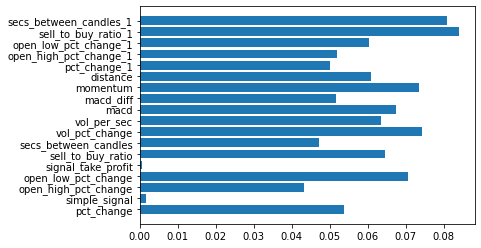

In [99]:
plt.barh(list(X), model_tp.feature_importances_)

In [100]:
# TODO:
# 1. Think on a model that would make for a good demo. There are several options:
#  a. Have labels that are related to some window in which the price changes significantly enough.
# We can reuse existing aggregations for such model.
#  b. Have a higher resolution of the aggregations (10k events instead of 1000 events for BTC). Can post-process existing data
# in fine resolution to arrive at new aggregations using a Python script.
#  c. Select a high-volume and high-volatility pair (e.g. ETHUSDT) that would yield signals more often.

In [101]:
# df.dropna(inplace=True)

In [102]:
# df.to_csv('ethbtc.csv', index=False)